In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from tqdm import tqdm_notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
from manualeeg import ManualEEG
from evaluate import *

In [49]:
np.random.seed(0)

# 1. Loading data

In [4]:
path = '../data/'
f = h5py.File(path+'X_train.h5','r')
x = f['features']
y = pd.read_csv(path+'y_train.csv')

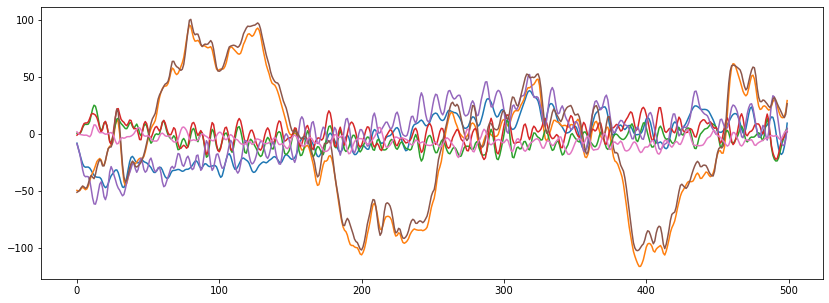

In [5]:
plt.figure(figsize=(14,5))
plt.plot(x[43,0,:,:].T)
plt.show()

In [6]:
indiv,rec,chan,pts  = x.shape
print(f'There are {indiv} people, {rec} recordings each, {chan} channels for each recording, {pts} points per channel per recording')

There are 946 people, 40 recordings each, 7 channels for each recording, 500 points per channel per recording


# 2. Extracting features

In [10]:
X = []
for indiv in tqdm_notebook(range(x.shape[0])):
    for rec in range(x.shape[1]):
        eeg = ManualEEG(x[indiv,rec,:,:],y.iloc[indiv]['label'],indiv)
        X.append(eeg.extractFeatures())

In [11]:
np.save('features.npy',X)

In [12]:
Y = np.repeat(y['label'].values,40)

# 3. Fitting a model

In [13]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [14]:
xtrain,xtest = X[:40*750],X[40*750:]
ytrain,ytest = Y[:40*750],Y[40*750:]

In [15]:
prop_women = np.sum(ytest)/len(ytest)
print(f'Il y a {100*prop_women:.1f} % de femmes dans le test')

Il y a 19.4 % de femmes dans le test


In [50]:
clf_list = [DecisionTreeClassifier(random_state=0),
            RandomForestClassifier(n_estimators=20,random_state=0),
            ExtraTreesClassifier(n_estimators=50,random_state=0),
            GradientBoostingClassifier(n_estimators=100,learning_rate = 0.1,max_depth=3,random_state=0)]

names_list = ['Decision tree','Rf','Extra trees','Xgboost']

results = pd.DataFrame([],columns = ['accuracy','recall','precision'],index = names_list)

for clf,name in zip(clf_list,names_list):
    results.loc[name] = evaluate_with_voting(clf,xtrain,ytrain,xtest,ytest,thresh=0.2)

In [51]:
results

,accuracy,recall,precision
Decision tree,0.556122,0.197531,0.421053
Rf,0.795918,0.333333,0.0526316
Extra trees,0.80102,0,0
Xgboost,0.790816,0.2,0.0263158
